# Convolutional Neural Network Training

Author: Zhongyi (James) Guo <br>
Date: 11/07/2024

## Import Packages

In [2]:
# system
import os
import pickle
import gzip

# data manipulation
import pandas as pd
import numpy as np

# deep learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-11-07 23:08:36.136477: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 23:08:36.860389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731020917.123087    3198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731020917.200111    3198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 23:08:37.890673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
os.getcwd()

'/home/ubuntu/SCA-DL-DGE/script/cnn'

## Import Dataset

In [4]:
with gzip.open('../../result/one_hot_encoding/gene_id_label_ohe.pkl.gz', 'rb') as f:
    data = pickle.load(f)

In [5]:
data

,ensembl_gene_id,DE,upstream_region_encoded
0,ENSG00000000457,1,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
1,ENSG00000000460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,..."
2,ENSG00000000938,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1,..."
3,ENSG00000000971,1,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,..."
4,ENSG00000001460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."
...,...,...,...
55221,ENSG00000284520,0,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."
55222,ENSG00000284544,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,..."
55223,ENSG00000284554,0,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1,..."
55224,ENSG00000284568,0,"[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."


## Quality Control

Verify that all entries in the `upstream_region_encoded` column have a consistent dimension of (2001, 4).

In [6]:
lengths = [len(row) for row in data['upstream_region_encoded']]
if len(set(lengths)) == 1:
    print("All rows have the same length:", lengths[0])
else:
    print("Rows have different lengths.")
    print("Unique lengths:", set(lengths))

Rows have different lengths.
Unique lengths: {1896, 2001, 546, 1827}


Some rows have entries in `upstream_region_encoded` that are not of length 2001, which we expected. This likely occurs because not all genes have an upstream region of exactly 2001 base pairs—some genes may be located close to the start of a chromosome, limiting the available upstream region. Therefore, we will remove genes with upstream regions that are not exactly 2001 bp.

In [7]:
data = data[data['upstream_region_encoded'].apply(lambda x: x.shape[0] == 2001)]

In [8]:
data

,ensembl_gene_id,DE,upstream_region_encoded
0,ENSG00000000457,1,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
1,ENSG00000000460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,..."
2,ENSG00000000938,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1,..."
3,ENSG00000000971,1,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,..."
4,ENSG00000001460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."
...,...,...,...
55221,ENSG00000284520,0,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."
55222,ENSG00000284544,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,..."
55223,ENSG00000284554,0,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1,..."
55224,ENSG00000284568,0,"[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."


Only 3 rows (genes) were removed.

In [9]:
X = np.stack(data['upstream_region_encoded'].values)
Y = data['DE'].values

In [10]:
print(X.shape)
print(Y.shape)

(55223, 2001, 4)
(55223,)


In [11]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Train-test Split

In [12]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123)

In [13]:
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

(44178, 2001, 4)
(11045, 2001, 4)
(44178,)
(11045,)


In [14]:
# add one more channel for the training purpose
X_train = np.expand_dims(X_train, axis=-1)
X_dev = np.expand_dims(X_dev, axis=-1) 

In [15]:
print(X_train.shape)
print(X_dev.shape)

(44178, 2001, 4, 1)
(11045, 2001, 4, 1)


Hyperparameters:

In [16]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
EPOCH_SIZE = 50

Shuffle the dataset and apply mini-batch gradient descent with a batch size of 256:

In [17]:
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dev = tf.data.Dataset.from_tensor_slices((X_dev, Y_dev))

I0000 00:00:1731021053.754285    3198 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [23]:
for batch in train.take(1):  
    X_batch, Y_batch = batch
    print("X_batch:", X_batch.shape) 
    print("Y_batch:", Y_batch.shape)

X_batch: (256, 2001, 4, 1)
Y_batch: (256,)


2024-11-07 23:13:01.244710: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model Building

In [33]:
model = models.Sequential()
model.add(layers.Input(shape=(2001, 4, 1), batch_size = BATCH_SIZE))
# Batch normalization (optional)
model.add(layers.Conv2D(16, (2, 2), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(32, (2, 2), activation='relu', padding='same'))
# Batch normalization (optional)
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [34]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (256, 2001, 4, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (256, 1001, 2, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (256, 1001, 2, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (256, 501, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (256, 16032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (256, 64)              │     1,026,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (256, 10)              │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,922 (3.93 MB)

 Trainable params: 1,028,922 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Training

In [36]:
history = model.fit(
    train,                  
    epochs=EPOCH_SIZE,        
    validation_data=dev     
)

Epoch 1/50


2024-11-07 23:20:10.122147: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:874] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-11-07 23:20:10.122188: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:877] Conv: %cudnn-conv.6 = (f32[16,32,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,256,1002,3]{3,2,1,0} %bitcast.1467, f32[32,256,1001,2]{3,2,1,0} %bitcast.1469), window={size=1001x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/sequential_4_1/conv2d_9_1/convolution/Conv2DBackpropFilter" source_file="/home/ubuntu/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_

172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8255 - loss: 0.5289

2024-11-07 23:20:21.781640: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:874] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-11-07 23:20:21.781684: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:877] Conv: %cudnn-conv.6 = (f32[16,32,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,146,1002,3]{3,2,1,0} %bitcast.1467, f32[32,146,1001,2]{3,2,1,0} %bitcast.1469), window={size=1001x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/sequential_4_1/conv2d_9_1/convolution/Conv2DBackpropFilter" source_file="/home/ubuntu/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8256 - loss: 0.5284

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 16032, but received input with shape (2001, 32)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(2001, 4, 1), dtype=int64)
  • training=False
  • mask=None

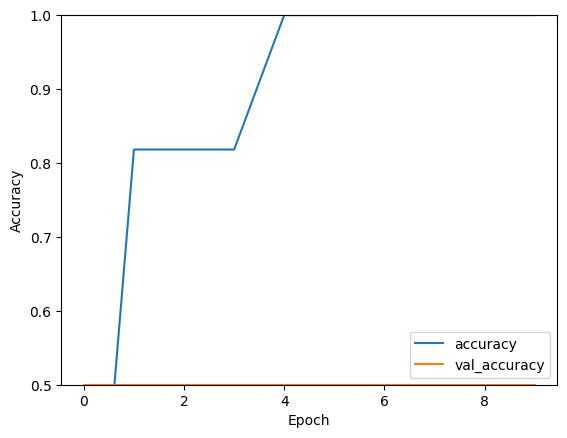

In [58]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)